In [1]:
import sklearn
# import shap

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Import base classifiers
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from baselines import AdaFairClassifier
from imbens.ensemble import SMOTEBoostClassifier, SMOTEBaggingClassifier, RUSBoostClassifier, UnderBaggingClassifier, SelfPacedEnsembleClassifier
from fairlearn.postprocessing import ThresholdOptimizer
from fairens import FairAugEnsemble, FairEnsemble

# Set GPU for matrix computations
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if device == 'cuda':
    torch.cuda.set_device(0)
    device_id = torch.cuda.current_device()
    print (f"Now using GPU #{device_id}:\n{torch.cuda.get_device_name(device_id)}")

# Import utilities
from data import FairDataset    # This is a custom class that we will use to load the datasets
from eval import evaluate_multi_split, verbose_print
from trainer import Trainer
from utils import seed_generator, dict_info, describe_data

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[FairAdapt]'


Now using GPU #0:
Tesla V100-SXM2-32GB


# Load dataset


In [2]:
"""Load Datasets"""

dataset_kwargs = {
    'y_col': 'label',
    'train_size': 0.6,
    'val_size': 0.2,
    'test_size': 0.2,
    'concat_train_val': True,
    'normalize': True,
    'random_state': 42,
}

all_datasets = {
    'compas': ['sex', 'race'],
    'adult': ['gender', 'race'],
    'bank': ['age', 'marital=married'],
    'lsa': ['gender', 'race'],
    'meps': ['SEX', 'RACE'],
    # 'lsa_unfair_gender_race': ['gender', 'race'],
}

"""
Create a dictionary of datasets: dataset_zoo
key: dataset name
value: FairDataset object
"""
dataset_zoo = {}
for dataname, s_attrs in all_datasets.items():
    for s_attr in s_attrs:
        dataset = FairDataset(
            dataname=dataname,
            csv_path=f'./data/{dataname}.csv',
            s_col=s_attr,
            **dataset_kwargs
        )
        dataset_zoo[dataset.fullname] = dataset

        # dataset.describe()
        dataset.brief()

# Print the information of the datasets and models
print(
    f"////// Dataset ZOO //////\n"
    f"{dict_info(dataset_zoo)}\n"
)

Dataset    : compas (5875, 12) load from ./data/compas.csv
Sens/Res   : sex/label
Split      : train/test = 0.8/0.2, random_state = 42, x_with_s = True
train      | size {0: 929, 1: 3771} | grp_pos_ratio: {0: 0.3617, 1: 0.4916}
test       | size {0: 232, 1: 943} | grp_pos_ratio: {0: 0.3621, 1: 0.491}

Dataset    : compas (5875, 12) load from ./data/compas.csv
Sens/Res   : race/label
Split      : train/test = 0.8/0.2, random_state = 42, x_with_s = True
train      | size {0: 1878, 1: 2822} | grp_pos_ratio: {0: 0.3946, 1: 0.5135}
test       | size {0: 469, 1: 706} | grp_pos_ratio: {0: 0.3945, 1: 0.5127}

Dataset    : adult (45222, 99) load from ./data/adult.csv
Sens/Res   : gender/label
Split      : train/test = 0.8/0.2, random_state = 42, x_with_s = True
train      | size {0: 11756, 1: 24421} | grp_pos_ratio: {0: 0.1136, 1: 0.3125}
test       | size {0: 2939, 1: 6106} | grp_pos_ratio: {0: 0.1136, 1: 0.3125}

Dataset    : adult (45222, 99) load from ./data/adult.csv
Sens/Res   : race/labe

In [3]:
from utils_unloc import DataProcessor, UnfairnessAttributer, ComparableSampleAnalyzer
from utils import generate_random_seeds

class UnLoc():
    
    def __init__(self) -> None:
        pass

    def _save_df(self, df, name, path='./data_cache/score'):
        df.to_csv(f"{path}/{name}.csv", index=False)

    def _load_df(self, name, path='./data_cache/score'):
        return pd.read_csv(f"{path}/{name}.csv")

    def compute_df_encoded(self, X, features, s_col):
        dp = DataProcessor()
        df_train_withs = pd.DataFrame(X, columns=features)
        idx_feats, num_feats, name_feats = dp.parse_feature_types(df_train_withs, verbose=False)
        df_train_withs_nooh, feats_con, feats_cat = dp.get_reverse_onehot_dataframe(df_train_withs, name_feats, encode=False)
        self.df_train_withs = df_train_withs
        self.df_train_withs_nooh = df_train_withs_nooh
        self.name_feats_withs = name_feats
        
        # we dont use sensitive attribute for computing comparable samples
        df_train = pd.DataFrame(X, columns=features).drop(s_col, axis=1)
        idx_feats, num_feats, name_feats = dp.parse_feature_types(df_train, verbose=False)
        df_train_encoded, feats_con, feats_cat = dp.get_reverse_onehot_dataframe(df_train, name_feats)

        self.df_train = df_train
        self.df_train_encoded = df_train_encoded
        self.feats_con = feats_con
        self.feats_cat = feats_cat
        self.name_feats = name_feats
        
    def fit_transform(self, X, y, s, data_split_info, features, s_col, prox_kwargs, s_prv=1, s_prt=0):
        # guarantee X's 1st column is sensitive attribute
        assert (X[:, 0] == s).all()
        
        file_name = f"{data_split_info}_{str(prox_kwargs)}_score"
        
        self.compute_df_encoded(X, features, s_col)

        try:
            df_score = self._load_df(file_name)
            print(f"Loaded score from {file_name}.csv")
            return df_score
        except:
            pass

        P = self.get_proximity(X, y, s, data_split_info, features, s_col, prox_kwargs, s_prv=s_prv, s_prt=s_prt)

        # compute confidence score
        attributer = UnfairnessAttributer(P)
        df_score = attributer.compute_confidence(X, y, s, s_prv=s_prv, s_prt=s_prt)

        # save df_score
        self._save_df(df_score, file_name)
        print(f"Saved score to {file_name}.csv")

        return df_score

    def get_proximity(self, X, y, s, data_split_info, features, s_col, prox_kwargs, s_prv=1, s_prt=0):
        
        df_train_encoded, feats_con, feats_cat = self.df_train_encoded, self.feats_con, self.feats_cat
        
        csa = ComparableSampleAnalyzer(
            df_train_encoded, feats_con, feats_cat, 
            save_path='data_cache', data_setting=data_split_info, 
            compress=False, verbose=True
        )
        P = csa.get_proximity(**prox_kwargs)
        return P
    

    def fair_aug(
        self, aug_ratio, X_train, y_train, s_train, P, 
        s_prv=1, s_prt=0, filter=None, weights=None, dummy=False, random_seed=None, verbose=False
    ):
        if aug_ratio == 0:
            return X_train, y_train, s_train, 0
        
        if filter is not None:
            if filter == 'prt-pos':
                mask_seeds = (y_train == 1) & (s_train == s_prt)
            elif filter == 'pos':
                mask_seeds = (y_train == 1)
            else:
                raise NotImplementedError
        else: mask_seeds = np.ones(len(y_train), dtype=bool)
        
        if weights is None or dummy:
            weights = np.ones(len(y_train), dtype=float)
        else:
            assert weights.shape == y_train.shape

        seed_weights = weights[mask_seeds]
        seed_weights /= seed_weights.sum()
        
        # compute n aug
        n_aug = int(aug_ratio * len(seed_weights))
        
        # sample seeds
        idx_seeds = np.where(mask_seeds)[0]
        np.random.seed(random_seed)
        idx_aug_seeds = np.random.choice(
            idx_seeds, n_aug, p=seed_weights, replace=True
        )

        random_seeds = generate_random_seeds(n_aug, random_seed)

        X_new, y_new, s_new = [], [], []

        for i, idx_seed in enumerate(idx_aug_seeds):
            rand_seed = random_seeds[i]
            idx_mixup = get_mixup_idx(
                idx_seed, P, y_train, s_train,
                group_constraint='same', label_constraint='diff', 
                top_n=10, random_seed=rand_seed
            )
            _, x_new_input = mixup_instance(
                idx_seed, idx_mixup, 
                self.df_train_withs_nooh, 
                self.df_train_withs, 
                self.name_feats_withs, 
                seed=rand_seed
            )
            X_new.append(x_new_input)
            y_new.append(y_train[idx_seed])
            s_new.append(s_train[idx_seed])
        
        X_edited = np.concatenate([X_train, np.array(X_new)], axis=0)
        y_edited = np.concatenate([y_train, np.array(y_new)], axis=0)
        s_edited = np.concatenate([s_train, np.array(s_new)], axis=0)
        
        if verbose:
            print(
                f"{len(y_edited) - len(y_train)} samples added from the dataset.\n"
                f"Dataset shape: {X_train.shape} -> {X_edited.shape}\n"
                f"S distribution {np.unique(s_train, return_counts=True)} -> {np.unique(s_edited, return_counts=True)}\n"
                f"Y distribution {np.unique(y_train, return_counts=True)} -> {np.unique(y_edited, return_counts=True)}"
            )

        return X_edited, y_edited, s_edited, n_aug
        

    def fair_removal(
        self, X_train, y_train, s_train, weights, edit_ratio, how='removal',
        s_prv=1, s_prt=0, filter=None, verbose=False, dummy=False, random_state=42,
    ):
        # Sort indices by descending weights
        sorted_indices = np.argsort(weights)[::-1]

        if filter is not None:
            if filter == 'prt-neg':
                filter_idx = (y_train[sorted_indices] == 0) & (s_train[sorted_indices] == s_prt)
            elif filter == 'prv-pos':
                filter_idx = (y_train[sorted_indices] == 1) & (s_train[sorted_indices] == s_prv)
            elif filter == 'prt-neg-prv-pos':
                filter_idx = ((y_train[sorted_indices] == 0) & (s_train[sorted_indices] == s_prt)) | ((y_train[sorted_indices] == 1) & (s_train[sorted_indices] == s_prv))
            elif filter == 'prv':
                filter_idx = (s_train[sorted_indices] == s_prv)
            elif filter == 'prt':
                filter_idx = (s_train[sorted_indices] == s_prt)
            elif filter == 'neg':
                filter_idx = (y_train[sorted_indices] == 0)
            elif filter == 'pos':
                filter_idx = (y_train[sorted_indices] == 1)
            else:
                raise NotImplementedError

            sorted_indices = sorted_indices[filter_idx]
        
        n_edit = int(edit_ratio * len(sorted_indices))
        # select the removal indices
        edit_indices = sorted_indices[:n_edit]

        if dummy:
            # set seed
            np.random.seed(random_state)
            edit_indices = np.random.choice(sorted_indices, n_edit, replace=False)
        else:
            edit_indices = sorted_indices[:n_edit]
        
        # Create edit mask
        if how == 'remove':
            keep_mask = np.ones(len(X_train), dtype=bool)
            keep_mask[edit_indices] = False
            # Apply undersampled mask
            X_edited = X_train[keep_mask]
            y_edited = y_train[keep_mask]
            s_edited = s_train[keep_mask]
        elif how == 'relabel':
            relabel_mask = np.zeros(len(X_train), dtype=bool)
            relabel_mask[edit_indices] = True
            y_edited = y_train.copy()
            y_edited[relabel_mask] = 1 - y_edited[relabel_mask]
            X_edited = X_train
            s_edited = s_train
        else: raise NotImplementedError
        
        if verbose:
            print(
                f"{len(y_train) - len(y_edited)} samples removed from the dataset.\n"
                f"Dataset shape: {X_train.shape} -> {X_edited.shape}\n"
                f"S distribution {np.unique(s_train, return_counts=True)} -> {np.unique(s_edited, return_counts=True)}\n"
                f"Y distribution {np.unique(y_train, return_counts=True)} -> {np.unique(y_edited, return_counts=True)}"
            )
        return X_edited, y_edited, s_edited, n_edit

In [10]:
import tqdm
from sklearn.base import clone
from eval import evaluate

def run_unloc_remove_relabel_exp(
        unloc, dataset_zoo, base_model_zoo, edit_ratio_space, setting_space, prox_kwargs, how,
        n_splits=5, n_runs=1, random_state=42, verbose=False
):
    print(
        f"////// Baseline Experiment //////\n"
        f"Base Model Zoo:       {list(base_model_zoo.keys())}\n"
        f"Dataset Zoo:          {list(dataset_zoo.keys())}\n"
        f"edit_ratio_space:     {edit_ratio_space}\n"
        # f"setting_space:        {setting_space}\n"
        f"n_splits:             {n_splits}\n"
        f"n_runs:               {n_runs}\n"
        f"random_state:         {random_state}\n"
    )
    
    all_res = []

    for data_name, data in dataset_zoo.items():

        for base_model_name, base_model in base_model_zoo.items():

            for i_run in range(n_runs):

                print (f"Data: {data_name} | Run: {i_run} | Base: {base_model_name}")
                rand_seed = random_state + i_run

                base_model = base_model.set_params(random_state=rand_seed)
                
                for i_split in range(n_splits):
                    
                    print (f"Data: {data_name} | Run: {i_run} | Base: {base_model_name} | split {i_split}")
                    
                    # get the i-th split of a n-fold cross validation
                    (
                        (X_train, y_train, s_train),
                        (X_val, y_val, s_val),
                        (X_test, y_test, s_test),
                        (idx_train, idx_val, idx_test)
                    ) = data.get_subgroup_split(
                        i_split=i_split, 
                        random_state=rand_seed,
                        n_splits=n_splits
                    )
                    
                    data_split_info = f"{data.fullname}_split[{i_split+1}of{n_splits}]_seed[{rand_seed}]"
                    unloc = UnLoc()
                    df_score = unloc.fit_transform(
                        X_train, y_train, s_train, data_split_info, 
                        features=data.feature_names, 
                        s_col=data.s_col,
                        prox_kwargs=prox_kwargs,
                    )

                    for setting_name, setting_kwargs in setting_space.items():
                            
                        weights = df_score[setting_kwargs['weights']]
                        dummy = setting_kwargs['dummy']
                        f = setting_kwargs['filter']

                        for edit_ratio in tqdm.tqdm(edit_ratio_space, disable=verbose, desc=f"{setting_name} - n_edit"):

                            X_edited, y_edited, s_edited, n_edit = unloc.fair_removal(
                                X_train, y_train, s_train,
                                how=how,
                                edit_ratio=edit_ratio,
                                weights=weights,
                                dummy=dummy,
                                filter=f, 
                                verbose=False
                            )
                            
                            clf = clone(base_model)
                            clf.set_params(random_state=rand_seed)
                            clf.fit(X_edited, y_edited)
                            
                            res = evaluate(clf, X_test, y_test, s_test)
                            
                            all_res.append({
                                **res,
                                'how': how,
                                'setting': setting_name,
                                'n_edit': n_edit,
                                'edit_ratio': edit_ratio,
                                'dataset': data_name,
                                'base_model': base_model_name,
                                'i_run': i_run,
                                'i_split': i_split,
                            })
                            if verbose:
                                res_vis = res.copy()
                                for k, v in res_vis.items():
                                    if isinstance(v, float):
                                        res_vis[k] = np.round(v*100, 2)
                                print (f"split: {i_split} | n_edit {n_edit} | {res_vis}")
        
    df_res = pd.DataFrame(all_res)
    
    return df_res


base_model_zoo = {
    'LR': LogisticRegression(),
    # 'KN': KNeighborsClassifier(n_neighbors=5),
    # 'DT': DecisionTreeClassifier(max_depth=10),
    # 'MLP': MLPClassifier(hidden_layer_sizes=(8), max_iter=50),
    # 'ADA': AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=None), n_estimators=5),
    # 'BAG': BaggingClassifier(estimator=DecisionTreeClassifier(max_depth=None), n_estimators=5),
}
# n_space = np.linspace(0, 5000, 21).astype(int)
edit_ratio_space = np.linspace(0, 1, 101)
setting_space = setting_space = {
    'rand_prtneg': {'dummy': True, 'filter': 'prt-neg', 'weights': 'unf'},
    'disag_prtneg': {'dummy': False, 'filter': 'prt-neg', 'weights': 'unf'},
    'disag_contr_prtneg': {'dummy': False, 'filter': 'prt-neg', 'weights': 'unf_contr'},
}
prox_kwargs = {
    't_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 
    'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 
    'include_self': False
}
n_splits = 5
n_runs = 1
random_state = 42
verbose = False
how = 'remove'
# how = 'relabel'

unloc = UnLoc()

df_res = run_unloc_remove_relabel_exp(
    unloc, dataset_zoo, base_model_zoo, edit_ratio_space, setting_space, prox_kwargs=prox_kwargs, how=how, 
    n_splits=n_splits, n_runs=n_runs, random_state=random_state, verbose=verbose
)
df_res

////// Baseline Experiment //////
Base Model Zoo:       ['LR']
Dataset Zoo:          ['compas_sex', 'compas_race', 'adult_gender', 'adult_race', 'bank_age', 'bank_marital=married', 'lsa_gender', 'lsa_race', 'meps_SEX', 'meps_RACE']
edit_ratio_space:     [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.  ]
n_splits:             5
n_runs:               1
random_state:         42

Data: compas_sex | Run: 0 | Base: LR
Data: compas_sex | Run: 0 | Base: LR | split 0
Loaded score from compas_sex_split[1of5]_seed[42]_{'t_con': 0.1, 't_cat': 

rand_prtneg - n_edit:   3%|▎         | 3/101 [00:00<00:07, 12.54it/s]

disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:06<00:00, 15.38it/s]


Data: compas_sex | Run: 0 | Base: LR | split 1
Loaded score from compas_sex_split[2of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:06<00:00, 14.50it/s]


Data: compas_sex | Run: 0 | Base: LR | split 2
Loaded score from compas_sex_split[3of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:07<00:00, 13.64it/s]


Data: compas_sex | Run: 0 | Base: LR | split 3
Loaded score from compas_sex_split[4of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:06<00:00, 15.05it/s]


Data: compas_sex | Run: 0 | Base: LR | split 4
Loaded score from compas_sex_split[5of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:07<00:00, 12.81it/s]


Data: compas_race | Run: 0 | Base: LR
Data: compas_race | Run: 0 | Base: LR | split 0
Loaded score from compas_race_split[1of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:05<00:00, 17.41it/s]


Data: compas_race | Run: 0 | Base: LR | split 1
Loaded score from compas_race_split[2of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:05<00:00, 18.21it/s]


Data: compas_race | Run: 0 | Base: LR | split 2
Loaded score from compas_race_split[3of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:06<00:00, 15.20it/s]


Data: compas_race | Run: 0 | Base: LR | split 3
Loaded score from compas_race_split[4of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:05<00:00, 16.90it/s]


Data: compas_race | Run: 0 | Base: LR | split 4
Loaded score from compas_race_split[5of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:05<00:00, 17.74it/s]


Data: adult_gender | Run: 0 | Base: LR
Data: adult_gender | Run: 0 | Base: LR | split 0
Loaded score from adult_gender_split[1of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:31<00:00,  3.25it/s]


Data: adult_gender | Run: 0 | Base: LR | split 1
Loaded score from adult_gender_split[2of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:33<00:00,  3.00it/s]


Data: adult_gender | Run: 0 | Base: LR | split 2
Loaded score from adult_gender_split[3of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:34<00:00,  2.89it/s]


Data: adult_gender | Run: 0 | Base: LR | split 3
Loaded score from adult_gender_split[4of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:33<00:00,  3.00it/s]


Data: adult_gender | Run: 0 | Base: LR | split 4
Loaded score from adult_gender_split[5of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:34<00:00,  2.95it/s]


Data: adult_race | Run: 0 | Base: LR
Data: adult_race | Run: 0 | Base: LR | split 0
Loaded score from adult_race_split[1of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:34<00:00,  2.90it/s]


Data: adult_race | Run: 0 | Base: LR | split 1
Loaded score from adult_race_split[2of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:34<00:00,  2.91it/s]


Data: adult_race | Run: 0 | Base: LR | split 2
Loaded score from adult_race_split[3of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:32<00:00,  3.11it/s]


Data: adult_race | Run: 0 | Base: LR | split 3
Loaded score from adult_race_split[4of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:33<00:00,  3.06it/s]


Data: adult_race | Run: 0 | Base: LR | split 4
Loaded score from adult_race_split[5of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:33<00:00,  3.05it/s]


Data: bank_age | Run: 0 | Base: LR
Data: bank_age | Run: 0 | Base: LR | split 0
Loaded score from bank_age_split[1of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:19<00:00,  5.31it/s]


Data: bank_age | Run: 0 | Base: LR | split 1
Loaded score from bank_age_split[2of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:21<00:00,  4.77it/s]


Data: bank_age | Run: 0 | Base: LR | split 2
Loaded score from bank_age_split[3of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:18<00:00,  5.40it/s]


Data: bank_age | Run: 0 | Base: LR | split 3
Loaded score from bank_age_split[4of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:19<00:00,  5.22it/s]


Data: bank_age | Run: 0 | Base: LR | split 4
Loaded score from bank_age_split[5of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:20<00:00,  4.94it/s]


Data: bank_marital=married | Run: 0 | Base: LR
Data: bank_marital=married | Run: 0 | Base: LR | split 0
Loaded score from bank_marital=married_split[1of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:18<00:00,  5.34it/s]


Data: bank_marital=married | Run: 0 | Base: LR | split 1
Loaded score from bank_marital=married_split[2of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:20<00:00,  4.82it/s]


Data: bank_marital=married | Run: 0 | Base: LR | split 2
Loaded score from bank_marital=married_split[3of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:21<00:00,  4.65it/s]


Data: bank_marital=married | Run: 0 | Base: LR | split 3
Loaded score from bank_marital=married_split[4of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:23<00:00,  4.28it/s]


Data: bank_marital=married | Run: 0 | Base: LR | split 4
Loaded score from bank_marital=married_split[5of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:22<00:00,  4.42it/s]


Data: lsa_gender | Run: 0 | Base: LR
Data: lsa_gender | Run: 0 | Base: LR | split 0
Loaded score from lsa_gender_split[1of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:25<00:00,  3.94it/s]


Data: lsa_gender | Run: 0 | Base: LR | split 1
Loaded score from lsa_gender_split[2of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:27<00:00,  3.66it/s]


Data: lsa_gender | Run: 0 | Base: LR | split 2
Loaded score from lsa_gender_split[3of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:26<00:00,  3.88it/s]


Data: lsa_gender | Run: 0 | Base: LR | split 3
Loaded score from lsa_gender_split[4of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:27<00:00,  3.72it/s]


Data: lsa_gender | Run: 0 | Base: LR | split 4
Loaded score from lsa_gender_split[5of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:26<00:00,  3.77it/s]


Data: lsa_race | Run: 0 | Base: LR
Data: lsa_race | Run: 0 | Base: LR | split 0
Loaded score from lsa_race_split[1of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:27<00:00,  3.71it/s]


Data: lsa_race | Run: 0 | Base: LR | split 1
Loaded score from lsa_race_split[2of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:27<00:00,  3.66it/s]


Data: lsa_race | Run: 0 | Base: LR | split 2
Loaded score from lsa_race_split[3of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:26<00:00,  3.78it/s]


Data: lsa_race | Run: 0 | Base: LR | split 3
Loaded score from lsa_race_split[4of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:25<00:00,  3.92it/s]


Data: lsa_race | Run: 0 | Base: LR | split 4
Loaded score from lsa_race_split[5of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:27<00:00,  3.72it/s]


Data: meps_SEX | Run: 0 | Base: LR
Data: meps_SEX | Run: 0 | Base: LR | split 0
Loaded score from meps_SEX_split[1of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:16<00:00,  6.13it/s]


Data: meps_SEX | Run: 0 | Base: LR | split 1
Loaded score from meps_SEX_split[2of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:14<00:00,  6.97it/s]


Data: meps_SEX | Run: 0 | Base: LR | split 2
Loaded score from meps_SEX_split[3of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:15<00:00,  6.67it/s]


Data: meps_SEX | Run: 0 | Base: LR | split 3
Loaded score from meps_SEX_split[4of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:13<00:00,  7.49it/s]


Data: meps_SEX | Run: 0 | Base: LR | split 4
Loaded score from meps_SEX_split[5of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:13<00:00,  7.27it/s]


Data: meps_RACE | Run: 0 | Base: LR
Data: meps_RACE | Run: 0 | Base: LR | split 0
Loaded score from meps_RACE_split[1of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:14<00:00,  6.86it/s]


Data: meps_RACE | Run: 0 | Base: LR | split 1
Loaded score from meps_RACE_split[2of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:12<00:00,  7.90it/s]


Data: meps_RACE | Run: 0 | Base: LR | split 2
Loaded score from meps_RACE_split[3of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:14<00:00,  6.90it/s]


Data: meps_RACE | Run: 0 | Base: LR | split 3
Loaded score from meps_RACE_split[4of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:16<00:00,  6.26it/s]


Data: meps_RACE | Run: 0 | Base: LR | split 4
Loaded score from meps_RACE_split[5of5]_seed[42]_{'t_con': 0.1, 't_cat': 2, 'restart_prob': 0.1, 'mat_norm': 'sym', 'relax': True, 'max_relax': 3, 'relax_factor': 0.1, 'include_self': False}_score.csv


disag_contr_prtneg - n_edit: 100%|██████████| 101/101 [00:14<00:00,  7.03it/s]


,acc,bacc,ap,roc,f1,dp,eo,ge,si,acc_grp,...,g_adv,acc_cls,how,setting,n_edit,edit_ratio,dataset,base_model,i_run,i_split
0,0.694468,0.690494,0.606229,0.690494,0.691027,0.361539,0.436371,0.164382,0.214468,"{0: 0.69, 1: 0.696}",...,1,"{0: 0.75, 1: 0.631}",remove,rand_prtneg,0,0.00,compas_sex,LR,0,0
1,0.693617,0.689697,0.605367,0.689697,0.690222,0.357228,0.436371,0.164586,0.211915,"{0: 0.685, 1: 0.696}",...,1,"{0: 0.748, 1: 0.631}",remove,rand_prtneg,4,0.01,compas_sex,LR,0,0
2,0.693617,0.689697,0.605367,0.689697,0.690222,0.357228,0.436371,0.164586,0.211915,"{0: 0.685, 1: 0.696}",...,1,"{0: 0.748, 1: 0.631}",remove,rand_prtneg,8,0.02,compas_sex,LR,0,0
3,0.694468,0.690494,0.606229,0.690494,0.691027,0.356168,0.436371,0.164382,0.207660,"{0: 0.685, 1: 0.697}",...,1,"{0: 0.75, 1: 0.631}",remove,rand_prtneg,13,0.03,compas_sex,LR,0,0
4,0.692766,0.688899,0.604509,0.688899,0.689418,0.352918,0.436371,0.164788,0.207660,"{0: 0.681, 1: 0.696}",...,1,"{0: 0.746, 1: 0.631}",remove,rand_prtneg,17,0.04,compas_sex,LR,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15145,0.530786,0.595621,0.206657,0.595621,0.486818,0.570809,0.648054,0.090366,0.667193,"{0: 0.37, 1: 0.82}",...,0,"{0: 0.497, 1: 0.694}",remove,disag_contr_prtneg,5129,0.96,meps_RACE,LR,0,4
15146,0.481528,0.573928,0.196806,0.573928,0.450810,0.649983,0.734773,0.084630,0.740133,"{0: 0.295, 1: 0.818}",...,0,"{0: 0.433, 1: 0.715}",remove,disag_contr_prtneg,5182,0.97,meps_RACE,LR,0,4
15147,0.444901,0.549634,0.187408,0.549634,0.421343,0.709512,0.796436,0.082103,0.788443,"{0: 0.241, 1: 0.813}",...,0,"{0: 0.39, 1: 0.709}",remove,disag_contr_prtneg,5236,0.98,meps_RACE,LR,0,4
15148,0.412378,0.532198,0.181342,0.532198,0.395446,0.763048,0.857669,0.078353,0.831386,"{0: 0.189, 1: 0.814}",...,0,"{0: 0.35, 1: 0.715}",remove,disag_contr_prtneg,5289,0.99,meps_RACE,LR,0,4


In [11]:
file_name = f'./res_cache/unloc_rem_base{list(base_model_zoo.keys())}_seed{random_state}_split{n_splits}.csv'
df_res.to_csv(file_name, index=False)

print (f"Saved results to {file_name}")

Saved results to ./res_cache/unloc_rem_base['LR']_seed42_split5.csv


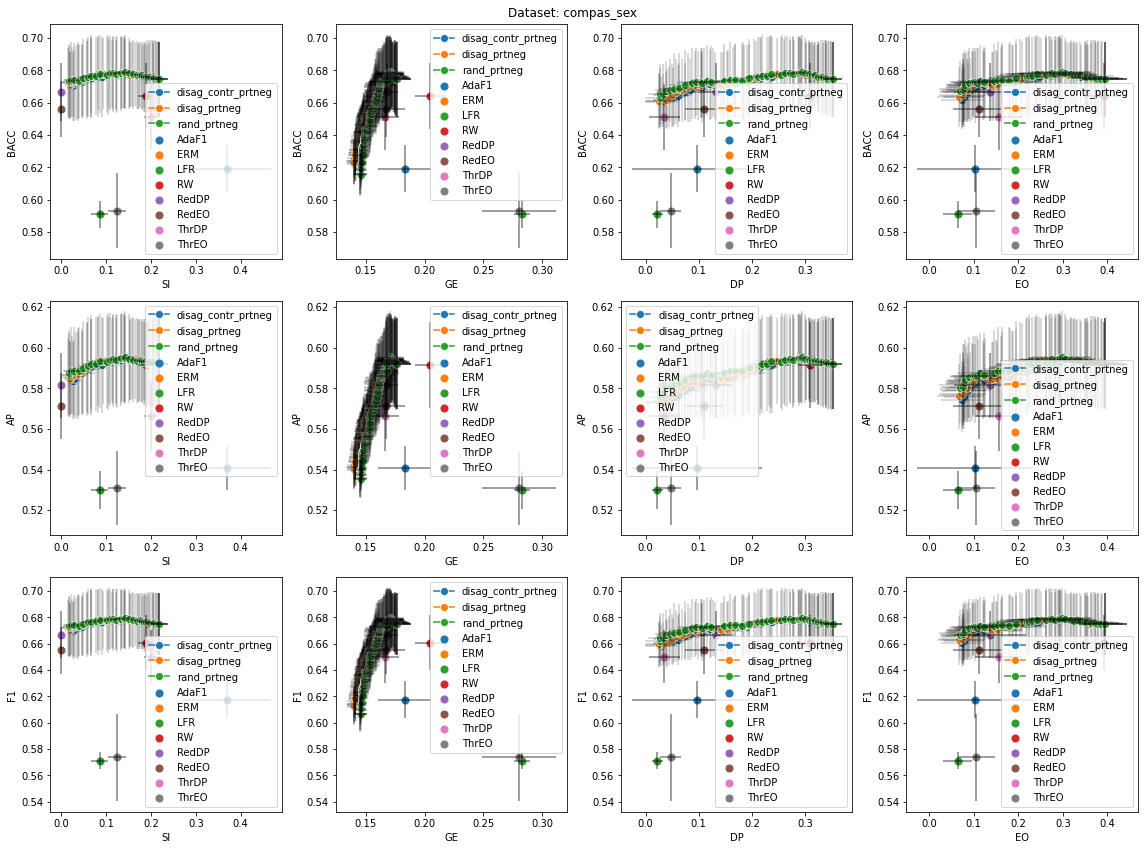

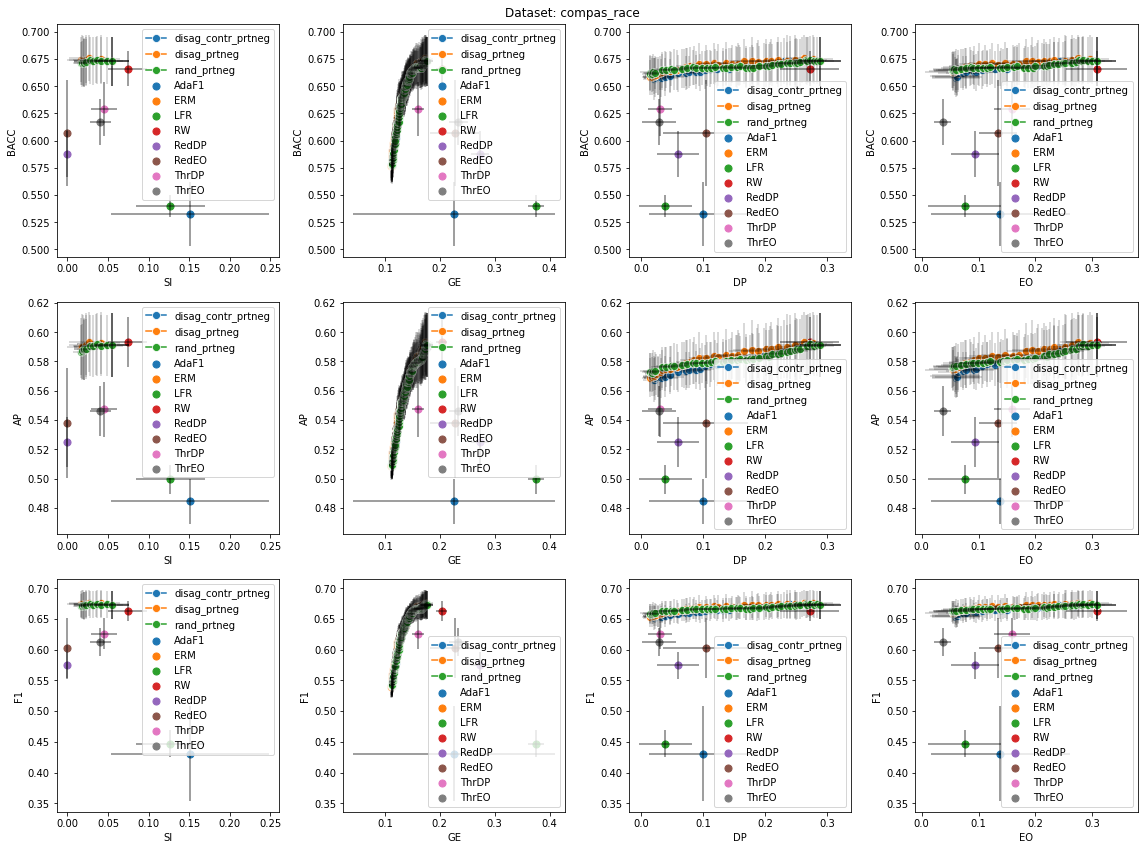

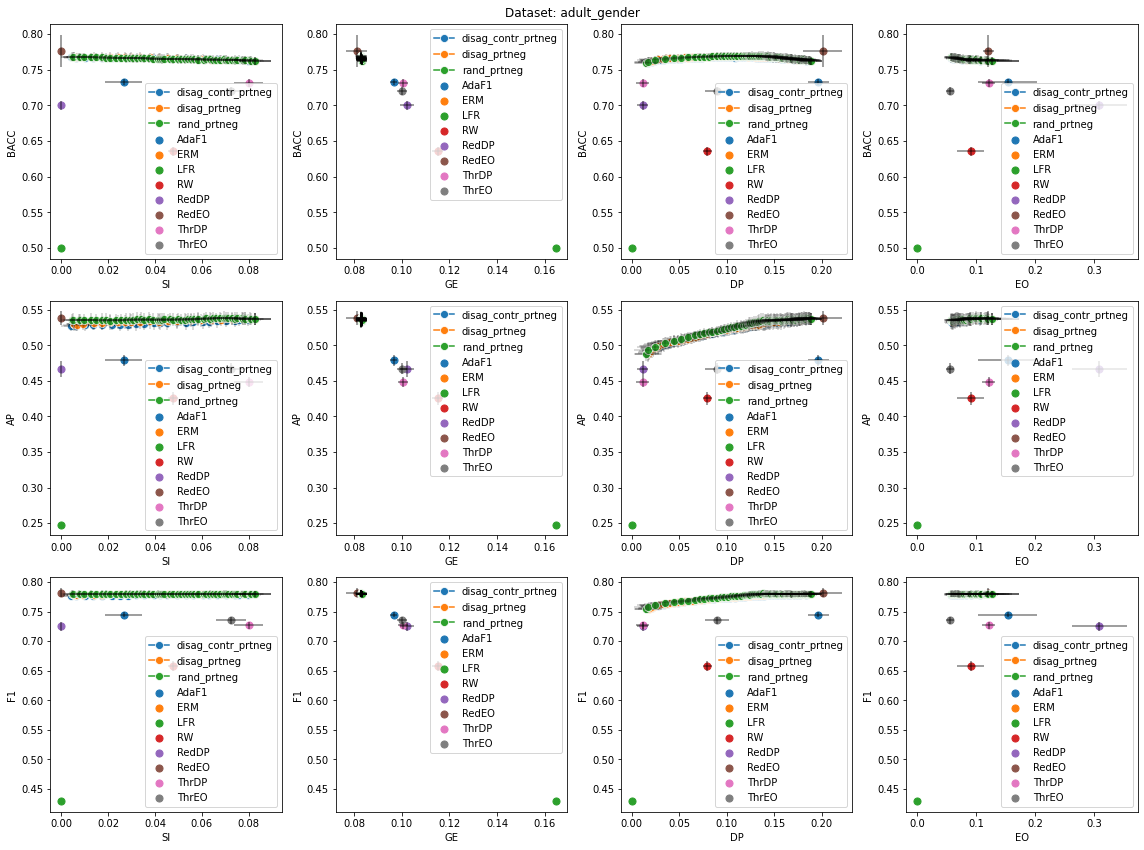

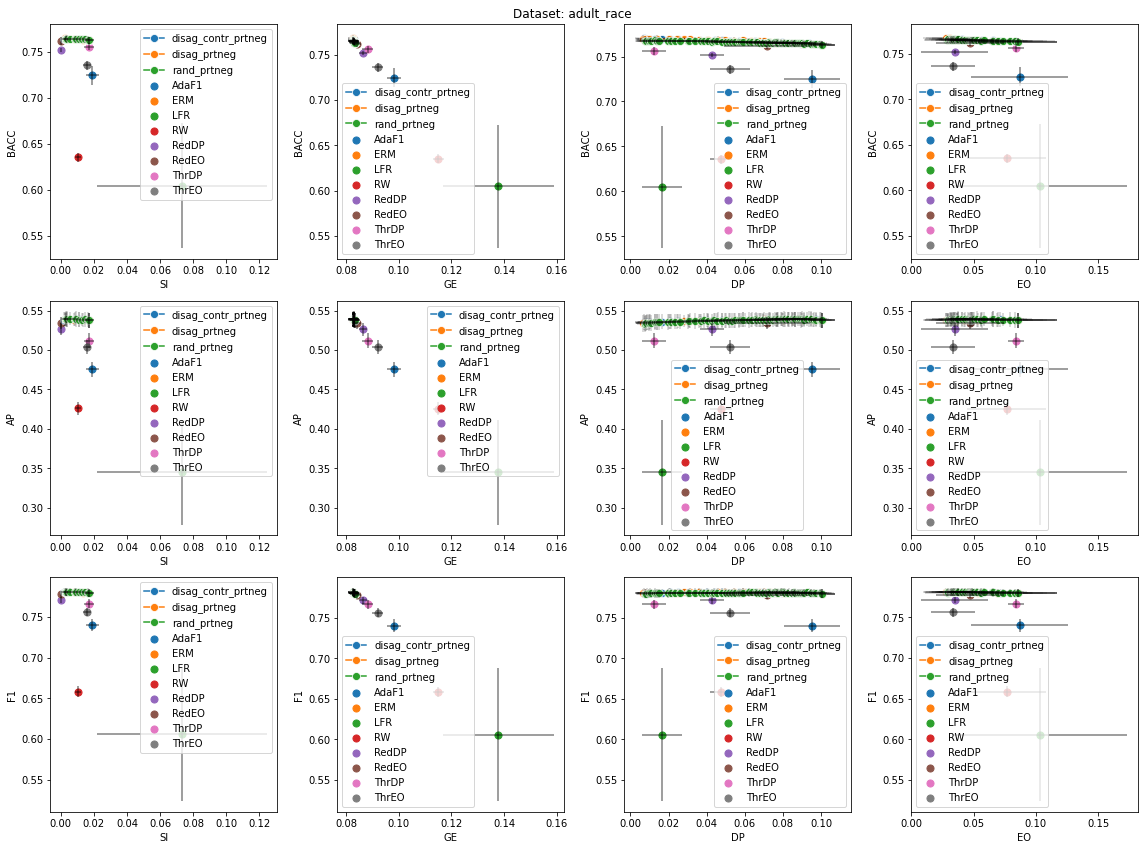

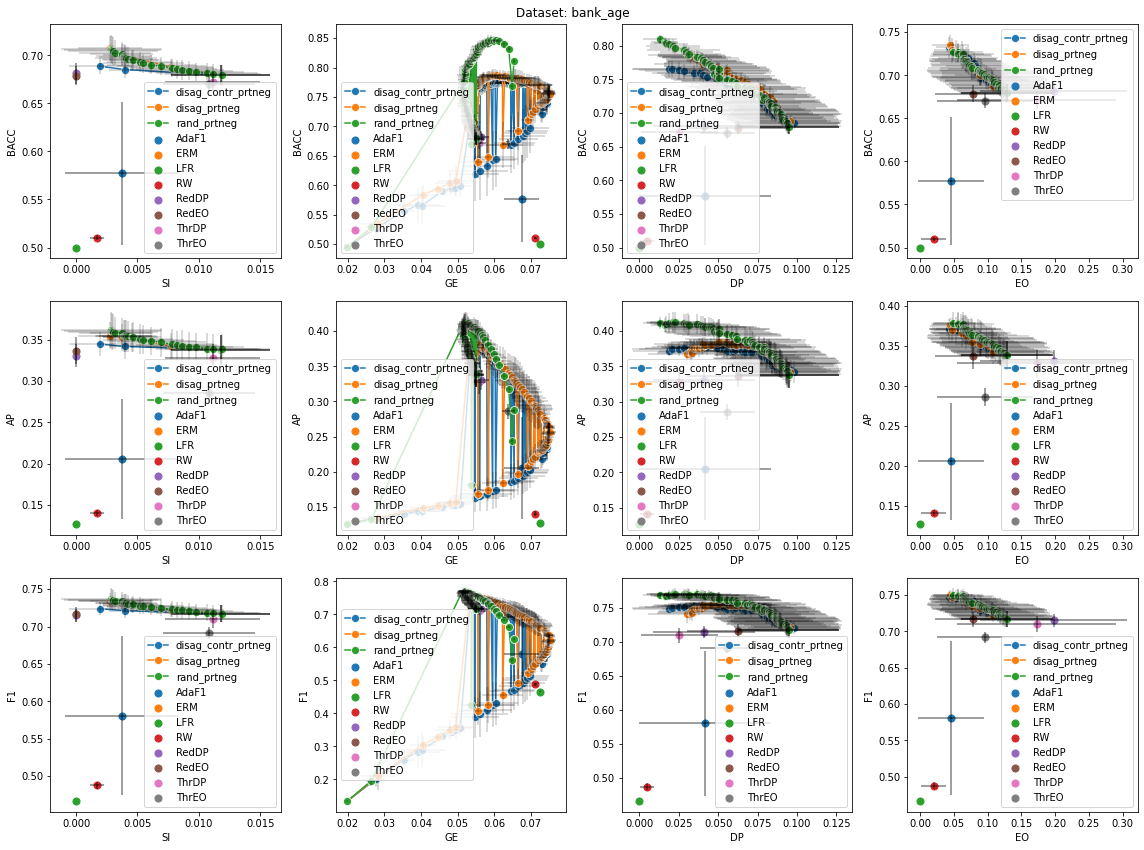

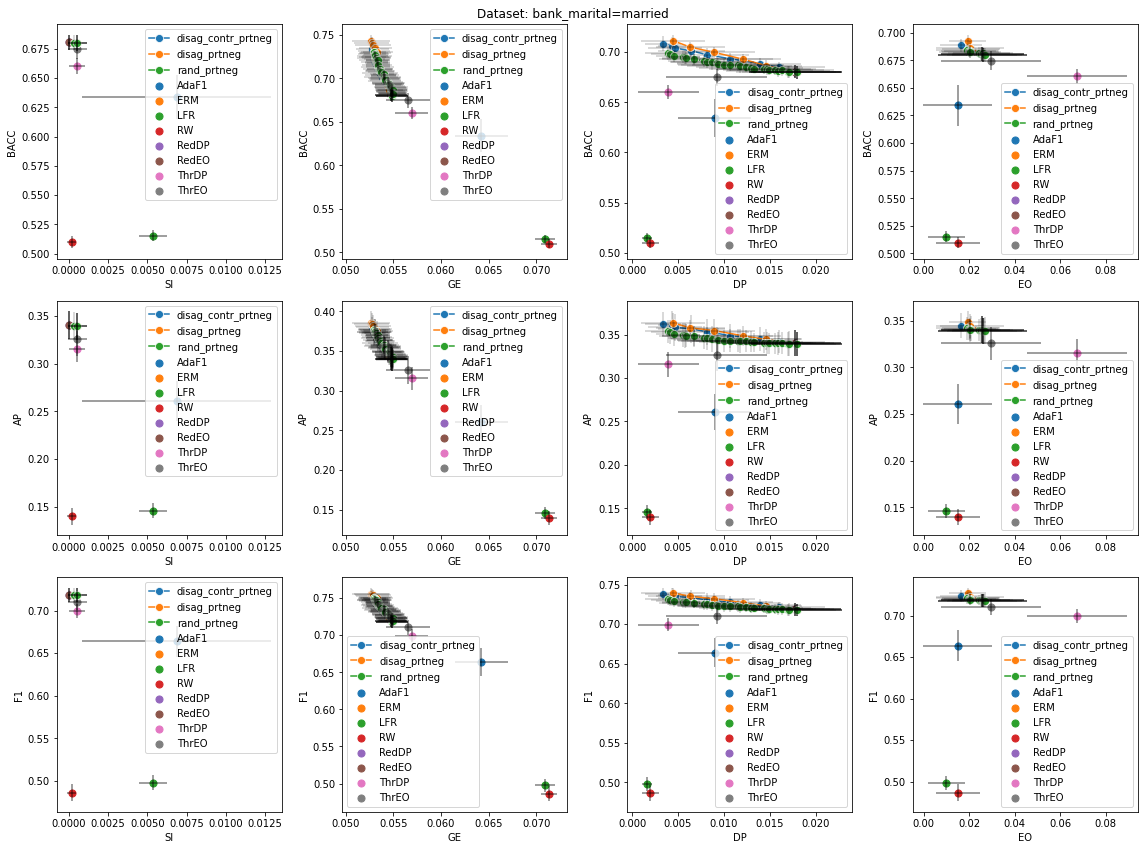

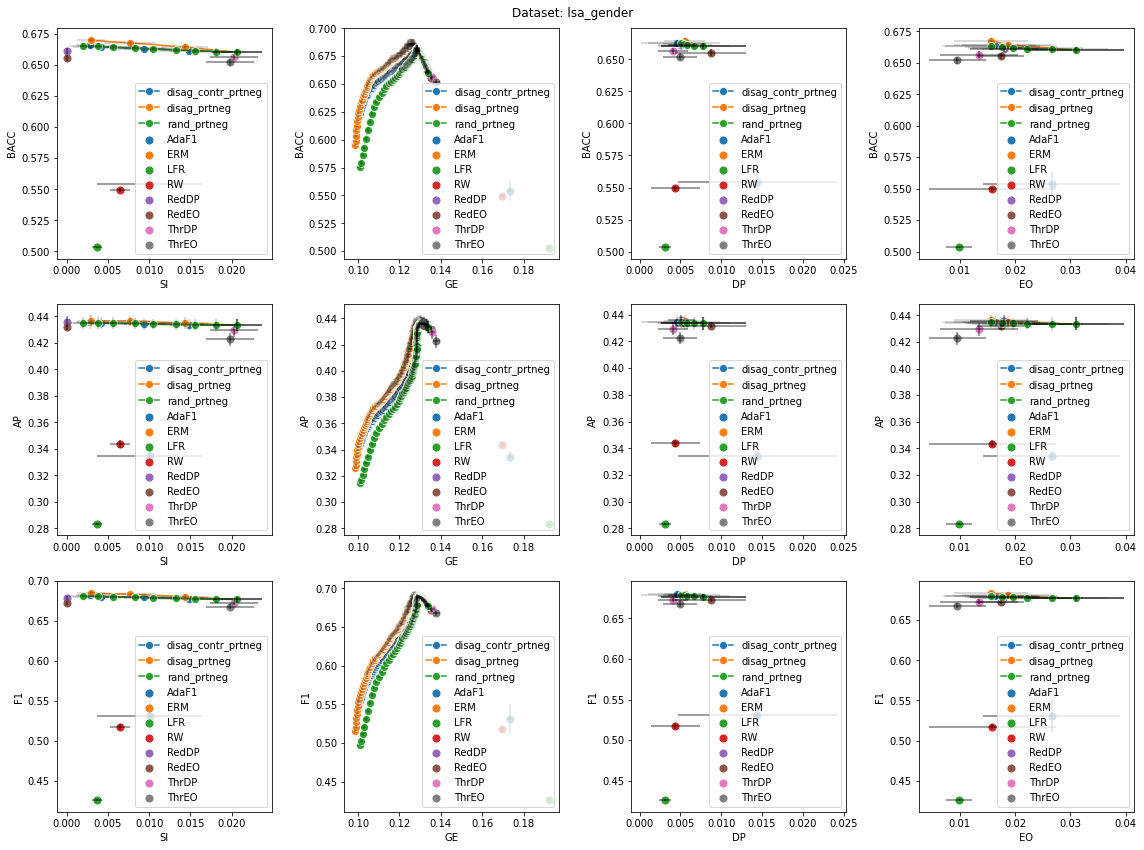

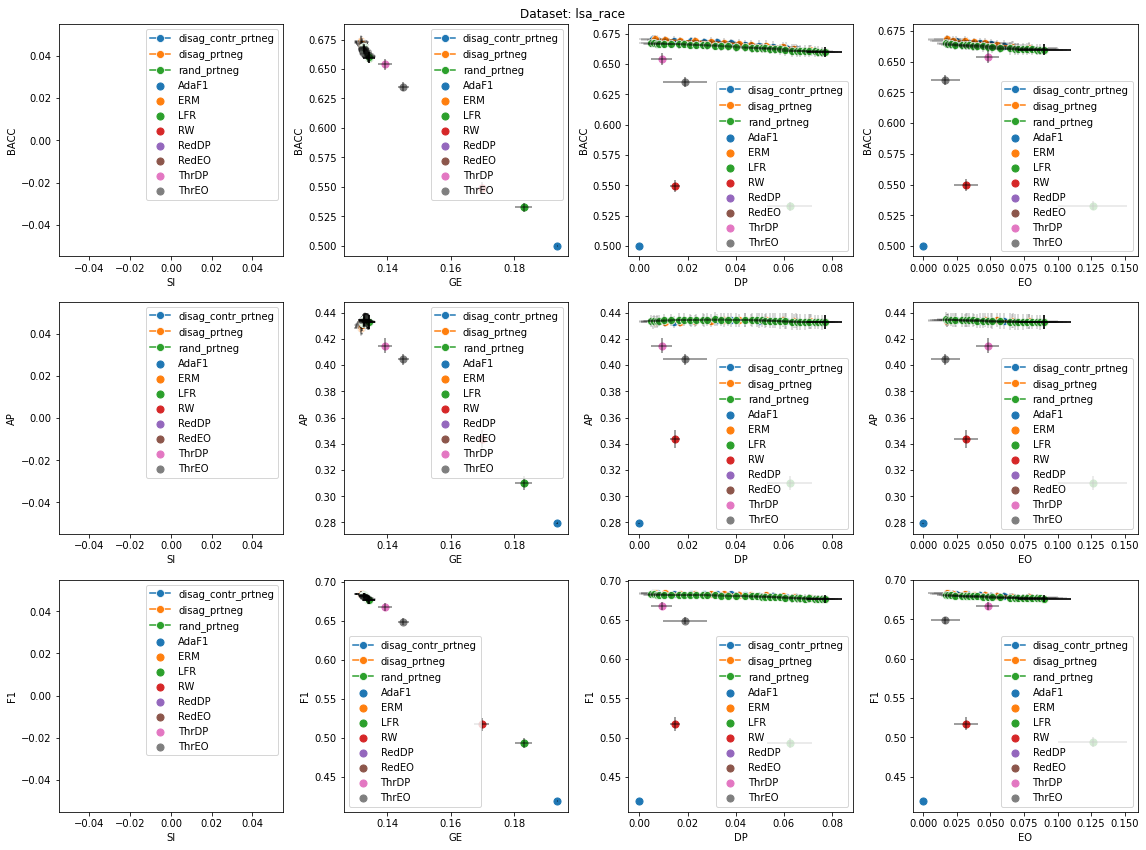

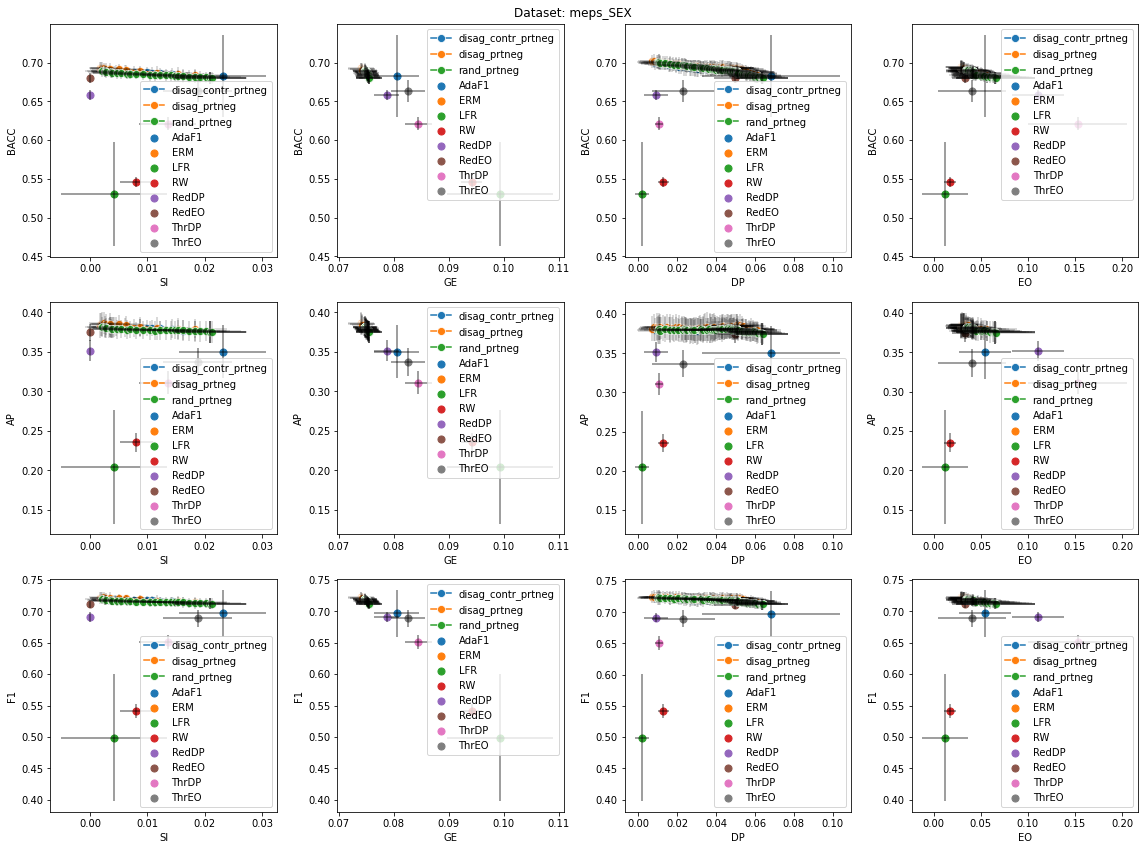

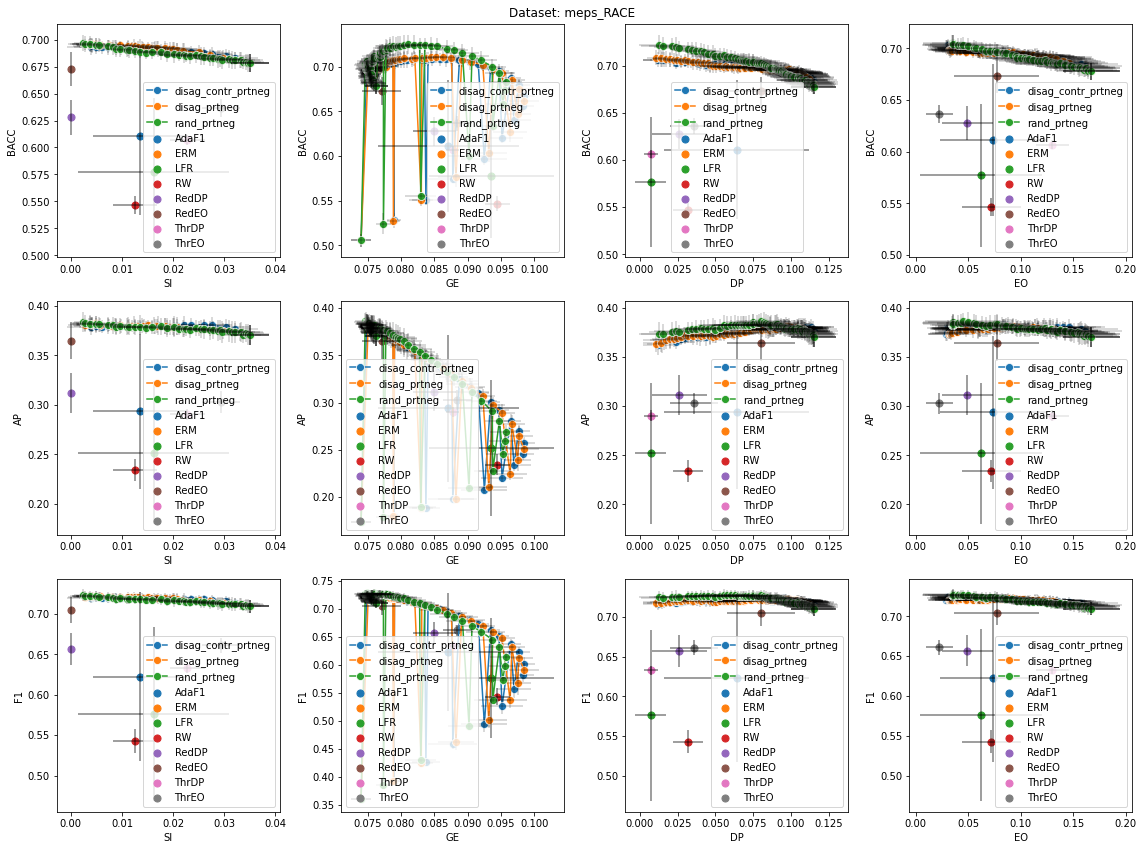

In [12]:
def plot_line_xy_tradeoff(
        df, x, y, group_key, style, monotonous='x', 
        ax=None, title=None, errorbar=False, **kwargs
):
    assert x in df.columns and y in df.columns
    assert group_key in df.columns and style in df.columns
    df_plot = df.groupby([group_key, style]).agg({x: ['mean', 'std'], y: ['mean', 'std']}).reset_index()

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    for style_val in df_plot[style].unique():
        df_subplot = df_plot[df_plot[style] == style_val]
        if monotonous == 'x':
            df_subplot = df_subplot.loc[:df_subplot[x]['mean'].idxmin()]
        else:
            raise NotImplementedError
        x_mean, x_std = df_subplot[x]['mean'], df_subplot[x]['std']
        y_mean, y_std = df_subplot[y]['mean'], df_subplot[y]['std']
        sns.lineplot(x_mean, y_mean, label=style_val, marker="o", markersize=8, ax=ax)
        if errorbar:
            ax.errorbar(
                x=x_mean, y=y_mean, xerr=x_std, yerr=y_std,
                ecolor='k', fmt='none', alpha=0.2,
                # capthick=2, capsize=5, 
            )
        ax.set(
            xlabel=x.upper(),
            ylabel=y.upper(),
        )
        ax.legend()
    return ax

def plot_scatter_xy_tradeoff(
        df, x, y, group_key, style, 
        ax=None, title=None, errorbar=False, **kwargs
):
    assert x in df.columns and y in df.columns
    assert group_key in df.columns and style in df.columns
    df_plot = df.groupby([group_key, style]).agg({x: ['mean', 'std'], y: ['mean', 'std']}).reset_index()

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    for style_val in df_plot[style].unique():
        df_subplot = df_plot[df_plot[style] == style_val]
        x_mean, x_std = df_subplot[x]['mean'], df_subplot[x]['std']
        y_mean, y_std = df_subplot[y]['mean'], df_subplot[y]['std']
        
        ax.scatter(x_mean, y_mean, label=style_val, marker="o", s=50)
        if errorbar:
            ax.errorbar(
                x=x_mean, y=y_mean, xerr=x_std, yerr=y_std,
                ecolor='k', fmt='none', alpha=0.5,
                # capthick=2, capsize=5, 
            )
        ax.set(
            xlabel=x.upper(),
            ylabel=y.upper(),
        )
        ax.legend()
    return ax


def plot_xy_group_tradeoff_with_baseline(
        df, df_baseline, xs, ys, group_key, style, monotonous='x', 
        subfig_size=(3, 3), **kwargs
):
    n_x, n_y = len(xs), len(ys)
    h_ax, w_ax = subfig_size

    dataset_unique = df['dataset'].unique()

    for data_name in dataset_unique:
        df_data = df[df['dataset'] == data_name]
        df_data_baseline = df_baseline[df_baseline['dataset'] == data_name]
        fig, axs = plt.subplots(n_y, n_x, figsize=(w_ax*n_x, h_ax*n_y))
        for i, x in enumerate(xs):
            for j, y in enumerate(ys):
                ax = plot_line_xy_tradeoff(df_data, x, y, group_key, style, monotonous, ax=axs[j, i], title=None, **kwargs)
                ax = plot_scatter_xy_tradeoff(df_data_baseline, x, y, group_key, 'method', ax=axs[j, i], title=None, **kwargs)
        plt.suptitle(f"Dataset: {data_name}")
        plt.tight_layout()
        plt.show()

df_baseline = pd.read_csv(f'./res_cache/baseline_clf{list(base_model_zoo.keys())}_seed{random_state}_split{n_splits}.csv')
df_baseline

plot_xy_group_tradeoff_with_baseline(
    df_res, df_baseline, 
    xs=['si', 'ge', 'dp', 'eo'], 
    # ys=['acc', 'bacc', 'ap', 'f1', 'roc'], 
    ys=['bacc', 'ap', 'f1'], 
    group_key='edit_ratio', style='setting', monotonous='x',
    subfig_size=(4, 4), errorbar=True,
)